In [1]:
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne
import pickle

# Read and preprocess the data

In [2]:
# reading CSV file
reader = csv.reader(open('data/SL2.csv', 'r'), delimiter=',')
train = np.array(list(reader))
reader = csv.reader(open('data/PL.csv', 'r'), delimiter=',')
test = np.array(list(reader))

In [3]:
print train

[['' '' '' ..., '' '' '']
 ['Date' 'Day of the week' '1-workday, 2-Saturday, 3-Sunday, >4-untypical'
  ..., 'Hour 22' 'Hour 23' 'Hour 24']
 ['19990101' '5' '4.01' ..., '364431' '357204' '324412']
 ..., 
 ['20011229' '6' '2' ..., '431338' '412652' '376991']
 ['20011230' '7' '3' ..., '432592' '414905' '370274']
 ['20011231' '1' '4.13' ..., '408512' '403538' '383141']]


In [4]:
labels = test[1,:]
print labels

['Date' 'Day of the week' '1-workday, 2-Saturday, 3-Sunday, >4-untypical'
 'Hour 1' 'Hour 2' 'Hour 3' 'Hour 4' 'Hour 5' 'Hour 6' 'Hour 7' 'Hour 8'
 'Hour 9' 'Hour 10' 'Hour 11' 'Hour 12' 'Hour 13' 'Hour 14' 'Hour 15'
 'Hour 16' 'Hour 17' 'Hour 18' 'Hour 19' 'Hour 20' 'Hour 21' 'Hour 22'
 'Hour 23' 'Hour 24']


In [5]:
train = np.delete(train, [0,1], 0)
date_train = train[0, :]
weekday_train = train[1, :]
day_type_train = train[2, :]
train_set = np.delete(train, [0,1,2], 1)

In [6]:
test = np.delete(test, [0,1], 0)
date_test = test[0, :]
weekday_test = test[1, :]
day_type_test = test[2, :]
test_set = np.delete(test, [0,1,2], 1)

In [7]:
train_set = np.array(train_set, dtype='float32')
test_set = np.array(test_set, dtype='float32')

In [8]:
train_set = np.reshape(train_set, train_set.shape[0]*train_set.shape[1])
test_set = np.reshape(test_set, test_set.shape[0]*test_set.shape[1])

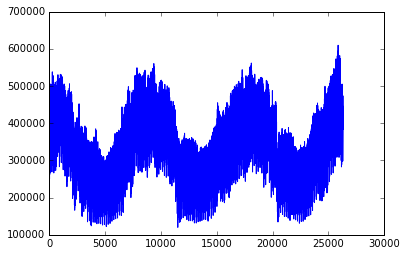

In [9]:
plt.plot(train_set)

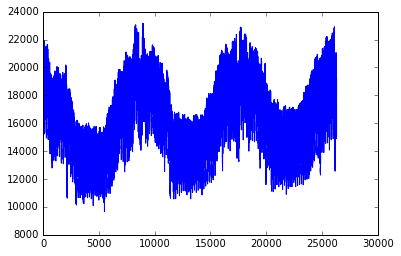

In [10]:
plt.plot(test_set)

In [109]:
def iterate_minibatches(source, seq_len=20, batch_size=10, pred_len=1):
    
    n = source.shape[0]
    ind = np.random.permutation(n-seq_len-pred_len).tolist()
    k = 0
    X_batch = np.zeros(shape=(batch_size, seq_len))
    y_batch = np.zeros(shape=(batch_size, pred_len))
    for start_index in ind:
        if k == batch_size:
            yield (X_batch, y_batch)
            X_batch = np.zeros(shape=(batch_size, seq_len))
            y_batch = np.zeros(shape=(batch_size, pred_len))
            k = 0
        else:
            X_batch[k] = source[start_index:start_index+seq_len]
            y_batch[k] = source[start_index+seq_len:start_index+seq_len+pred_len]
            k = k+1
       

In [18]:
def sample_random_batches(source, n_batches=10, seq_len=20, pred_len=1):
    """
    This function takes random subsequences from the time series.

    Parameters:
        source - initial time series
        n_batches - how many subsequences are to be sampled
        seq_len - length of each of such subsequences
        
    
    Return:
     X - a matrix of float32 with shape [n_batches,seq_len]
        Each row of such matrix must be a subsequence of source 
            starting from random index (from 0 to N-seq_len-2)
     Y - a vector, where i-th number is one going RIGHT AFTER i-th row from X from source
     
    """
    
    X_batch = np.zeros(shape=(n_batches, seq_len))
    y_batch = np.zeros(shape=(n_batches, pred_len))
    for i in range(n_batches):
        k = np.random.randint(0, len(source)-seq_len-1)
        X_batch[i] = source[k:k+seq_len]
        y_batch[i] = source[k+seq_len:k+seq_len+pred_len]
    
    return X_batch, y_batch

# Constants

In [19]:
#Training sequence length
seq_length = 240

#max gradient between recurrent layer applications
grad_clip = 100

#values to be predicted
pred_len = 10

# Input values

In [20]:
input_sequence = T.matrix('input sequence')
target_values = T.matrix('target y')

# Neural network architecture

In [31]:
b = train_set[0:seq_length].reshape((1,seq_length))

In [91]:
a = theano.function([input_sequence], lasagne.layers.get_output(l_out))

In [92]:
print a(b).shape

(1, 10)


In [67]:
q = np.array(1)

In [68]:
print np.repeat(q, pred_len)

[1 1 1 1 1 1 1 1 1 1]


In [90]:

l_in = lasagne.layers.InputLayer(shape=(None, seq_length),input_var=input_sequence)

l1 = lasagne.layers.ExpressionLayer(l_in, lambda X: T.repeat(X.mean(axis=1), pred_len), output_shape=(None, pred_len))
l1 = lasagne.layers.ReshapeLayer(l1, shape=(-1, pred_len))

l2 = lasagne.layers.ExpressionLayer(l_in, lambda X: T.repeat(X.std(axis=1), pred_len), output_shape=(None, pred_len))
l2 = lasagne.layers.ReshapeLayer(l2, shape=(-1, pred_len))

l3 = lasagne.layers.ExpressionLayer(l_in, lambda X: 
                                    ((X.reshape([1, X.shape[0]*X.shape[1]]) - T.repeat(X.mean(axis=1), seq_length))/
                                     T.repeat(X.std(axis=1), seq_length)).reshape(X.shape),
                                    output_shape=(None, seq_length))

l4 = lasagne.layers.ReshapeLayer(l3, shape=(-1, seq_length, 1))

l_rnn = lasagne.layers.LSTMLayer(l4, num_units=50, grad_clipping=grad_clip, 
                                    nonlinearity=lasagne.nonlinearities.tanh)
l_rnn = lasagne.layers.LSTMLayer(l_rnn, num_units=50, grad_clipping=grad_clip, 
                                    nonlinearity=lasagne.nonlinearities.tanh)

l_out_norm = lasagne.layers.DenseLayer(l_rnn, num_units=pred_len, nonlinearity=lasagne.nonlinearities.linear)

l_out_mul = lasagne.layers.ElemwiseMergeLayer([l_out_norm, l2], merge_function = T.mul)
l_out = lasagne.layers.ElemwiseSumLayer([l_out_mul, l1])

In [93]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print weights

[W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [94]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [95]:
network_output_norm = lasagne.layers.get_output(l_out_norm)

In [96]:
std = lasagne.layers.get_output(l2)

In [97]:
loss = T.mean(lasagne.objectives.squared_error(network_output/std, target_values/std))

#updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=2e-4, momentum=0.9)
updates = lasagne.updates.adam(loss, weights, learning_rate=2e-4)

# Compiling all functions

In [98]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

#forecasting next timestep
forecast = theano.function([input_sequence],network_output,allow_input_downcast=True)

# Function for saving trained parameters

In [99]:
def checkpoint(name):
    params = lasagne.layers.get_all_param_values(l_out)
    pickle.dump(params, open(name, 'wb'))

# Training loop

In [100]:
loss = []

In [110]:

print("Training ...")


#total N iterations
n_epochs=100

#how many training sequences are processed in a single function call
batch_size=500


for epoch in xrange(n_epochs):

    avg_cost = 0;
    for batch in iterate_minibatches(train_set, seq_length, batch_size, pred_len):
        x, y = batch        
        #x,y = sample_random_batches(train_set,batch_size,seq_length)
        avg_cost += train(x, y)
    
    loss.append(avg_cost)
    
    print("Epoch {} average loss = {}".format(epoch, avg_cost))


Training ...
Epoch 0 average loss = 28.7015929543
Epoch 1 average loss = 10.5083002446
Epoch 2 average loss = 7.78831035659
Epoch 3 average loss = 6.789011993
Epoch 4 average loss = 6.17313011972
Epoch 5 average loss = 5.66216274823
Epoch 6 average loss = 5.22816872915
Epoch 7 average loss = 4.90012009046
Epoch 8 average loss = 4.63294574984
Epoch 9 average loss = 4.42449215521
Epoch 10 average loss = 4.22074296705
Epoch 11 average loss = 4.05731768183
Epoch 12 average loss = 3.93542138453
Epoch 13 average loss = 3.81484919422
Epoch 14 average loss = 3.70479790035
Epoch 15 average loss = 3.61374011338
Epoch 16 average loss = 3.50493549986
Epoch 17 average loss = 3.42508332165
Epoch 18 average loss = 3.35484564166
Epoch 19 average loss = 3.27434843824
Epoch 20 average loss = 3.22960224221
Epoch 21 average loss = 3.17303047662
Epoch 22 average loss = 3.13667811032
Epoch 23 average loss = 3.07726047293
Epoch 24 average loss = 3.0556687403
Epoch 25 average loss = 3.00799999519
Epoch 26 ave

# Testing perfomance

In [229]:
print("Testing started...")

test_seq_len = 480

x,y = sample_random_batches(test_set,1,test_seq_len)
x_forecast = np.zeros((1, test_seq_len))
x_cur = np.zeros((1, seq_length))
x_forecast[:, 0:seq_length] = x[:, 0:seq_length] 

for start in xrange(test_seq_len-seq_length):

    x_cur = x_forecast[:, start:start+seq_length]
    x_forecast[:, start+seq_length] = forecast(x_cur)

print("Testing finished...")

Testing started...
Testing finished...


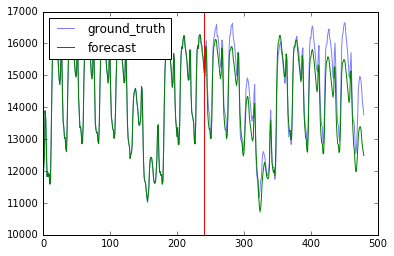

In [230]:
plt.plot(x[0], color='blue', label='ground_truth', alpha=0.5)
plt.plot(x_forecast[0], color='green', label='forecast')
plt.axvline(x=seq_length, linewidth=1, color='red')
plt.legend(loc=2)

In [231]:
#checkpoint('Version 4.0')

# Plotting results

## "Good" forecasts

In [197]:
length = [264, 288, 360, 480, 720, 960]

In [198]:
names=["One day forecast", "Two days forecast", "Five days forecast", "Ten days forecast", 
     "Twenty days forecast", "Month forecast"]

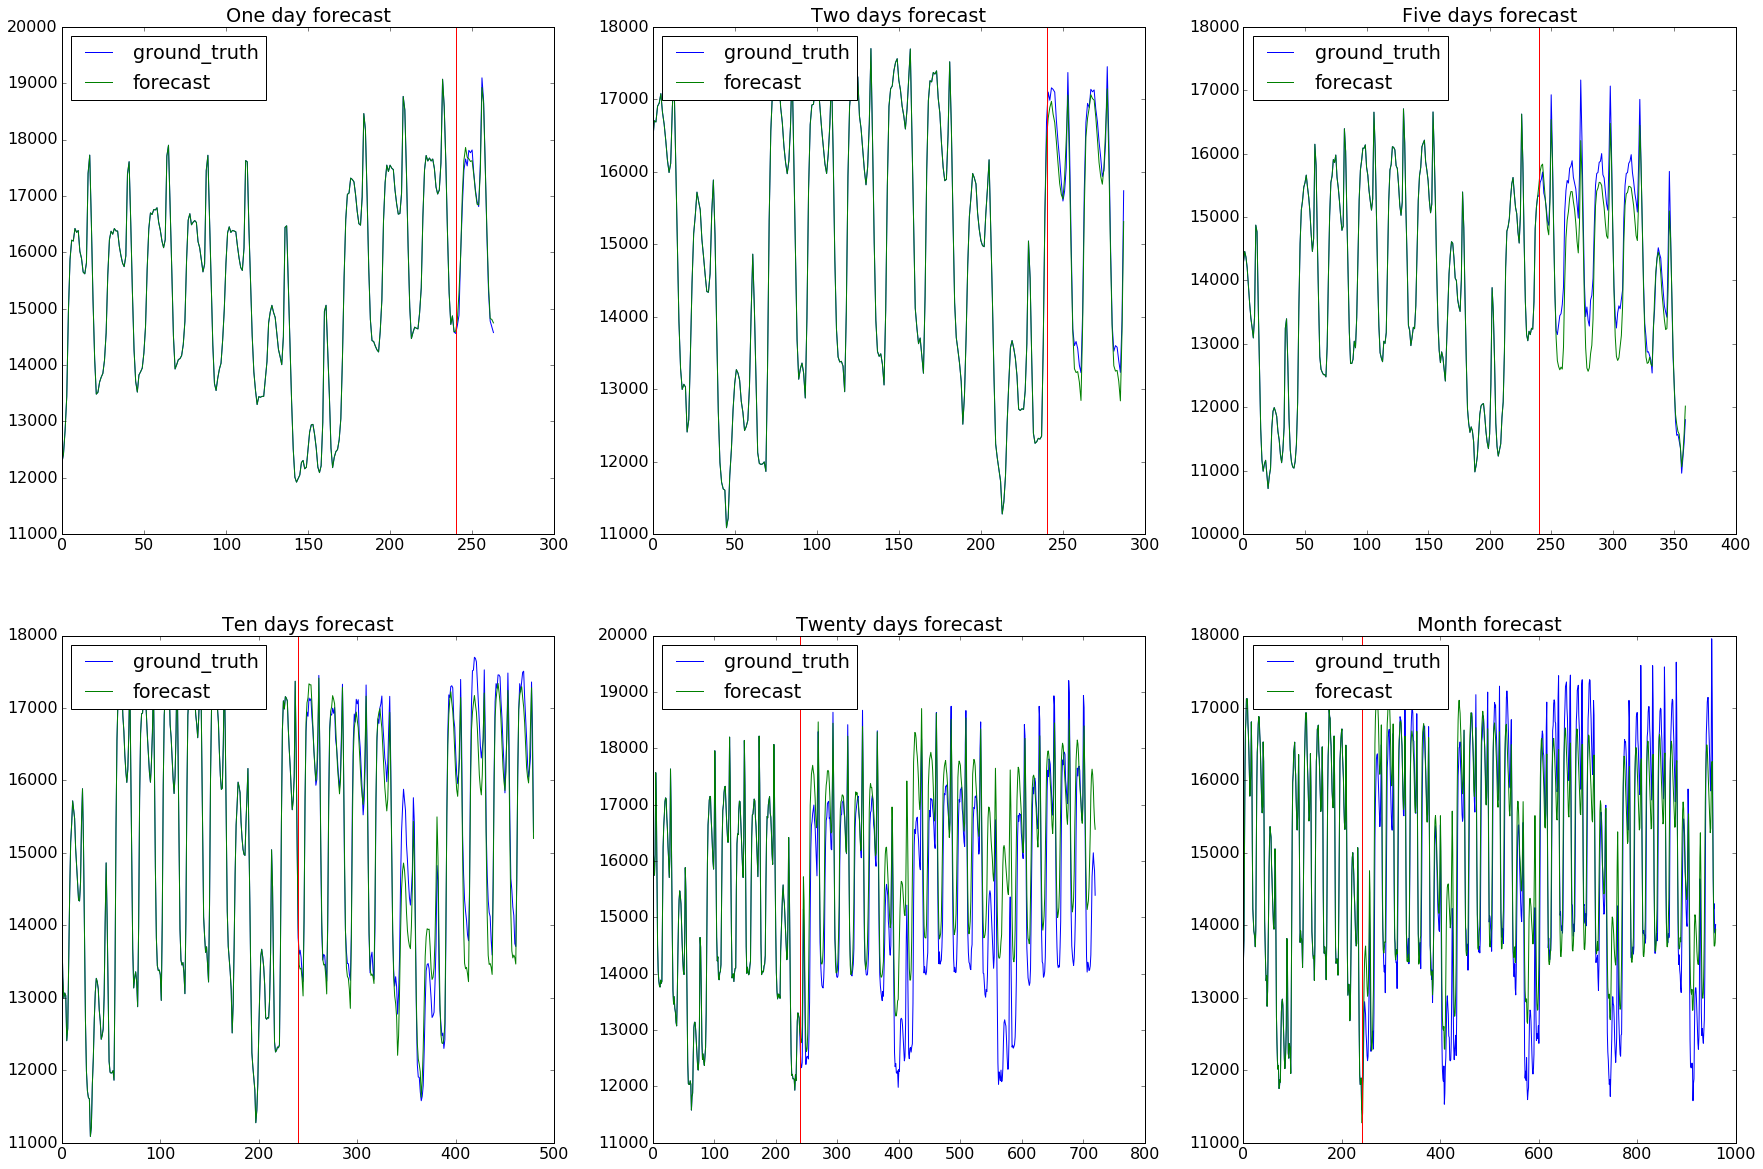

In [218]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,3, figsize=(30,20))
for i in range(2):
    for j in range(3):
        k = 3*i+j
        axes[i,j].plot(plots[k,0][0,0:length[k]], color='blue', label='ground_truth')
        axes[i,j].plot(plots[k,1][0,0:length[k]], color='green', label='forecast')
        axes[i,j].axvline(x=seq_length, linewidth=1, color='red')
        axes[i,j].legend(loc=2)
        axes[i,j].set_title(names[k])

## "Bad" forecasts

We are quite good at makin short-term forecsts (~10 days), but long-term forecast can go to infinity

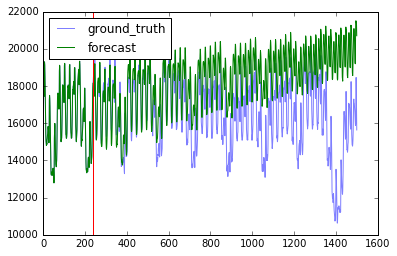

In [224]:
plt.rcParams.update({'font.size': 10})
plt.plot(x[0], color='blue', label='ground_truth', alpha=0.5)
plt.plot(x_forecast[0], color='green', label='forecast')
plt.axvline(x=seq_length, linewidth=1, color='red')
plt.legend(loc=2)